# Mecánica Celeste: teoría, algoritmos y problemas
# Por Jorge I. Zuluaga

En estos cuadernos hemos compilado la mayoría de los códigos que vienen con el libro [**Mecánica Celeste: teoría, algoritmos y problemas**](https://www.libreriadelau.com/bw-mecanica-celeste-teoria-algoritmos-y-problemas-u-de-antioquia-fisica/p). En cada cuaderno encontrará códigos de secciones o capítulos enteros. Para explicaciones detalladas de lo que hacen los códigos refiérase a la sección o capítulo respectivo. Para mayor comodidad puede leer o ejecutar este cuaderno usando `Google Colab`.

<a target="_blank" href="https://colab.research.google.com/github/seap-udea/pymcel/blob/main/ejemplos/cuadernos-libro/mcel_zuluaga-14-trescuepos-basico.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Algorítmos del problema de los tres cuepos

### Instalación e importación

Si está usando este cuaderno en `Colab` debería instalar `pymcel` antes de comenzar: 

In [1]:
!pip install -Uq pymcel

In [2]:
# Este código se usa solamente para desarrollar estos cuadernos pero es inocuo en otros contextos
%load_ext autoreload 
%autoreload 2

### Motivación

Un sistema de ejemplo

In [3]:
sistema=[
    # Particula 0
    dict(
        m=100.0,
        r=[-0.142857,0,0],
        v=[0,-2.958,0]
    ),
    # Particula 1
    dict(
        m=5.0,
        r=[2.85714,0,0],
        v=[0,2.958,0]
    ),
    # Particula 2
    dict(
        m=0.01,
        r=[3.62345,0,0],
        v=[0,4.9700007,0]
    )
]

Resolvamos numéricamente las ecuaciones de movimiento del sistema con las rutinas desarrolladas en el Capítulo *El problema de los N cuerpos*:

In [4]:
from numpy import linspace 
ts=linspace(0,3,100)

from pymcel.export import ncuerpos_solucion 
rs,vs,rps,vps,constantes=ncuerpos_solucion(sistema,ts)

Paquete pymcel cargado. Versión: 0.6.0


Grafiquemos el resultado:

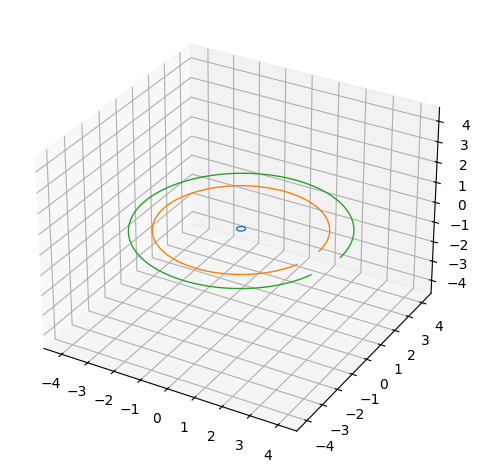

In [5]:
from pymcel.export import plot_ncuerpos_3d
fig=plot_ncuerpos_3d(rps,vps)
ax=fig.gca()

### El problema restringido de los tres cuerpos

Ecuación de movimiento:

In [6]:
def edm_crtbp(Y,t,alfa):

    r=Y[:3]
    v=Y[3:]
    
    #Vectores relativos
    from numpy import array
    r1=r-array([-alfa,0,0])
    r2=r-array([1-alfa,0,0])
    ez=array([0,0,1])
    
    #Aceleraciones
    from numpy.linalg import norm
    from numpy import cross
    g1=-(1-alfa)*r1/norm(r1)**3
    g2=-alfa*r2/norm(r2)**3
    acen=-cross(ez,cross(ez,r))
    acor=-2*cross(ez,v)
    a=g1+g2+acen+acor

    from numpy import concatenate
    dYdt=concatenate((v,a))
    return dYdt

Escojamos el valor de los parámetros claves de sistema y las condiciones iniciales para la partícula de prueba.



In [7]:
#Parámetro gravitacional del sistem
alfa=0.3

#Tiempos de integración
from numpy import linspace
Nt=1000
ts=linspace(0,10,Nt)

#Condiciones iniciales
from numpy import array,concatenate
ro=array([1.0,0.0,0.0])
vo=array([0.0,0.45,0.0])
Yo=concatenate((ro,vo))

#Solución
from scipy.integrate import odeint
Ys=odeint(edm_crtbp,Yo,ts,args=(alfa,))

Gráfica de la trayectoria en el sistema rotante:

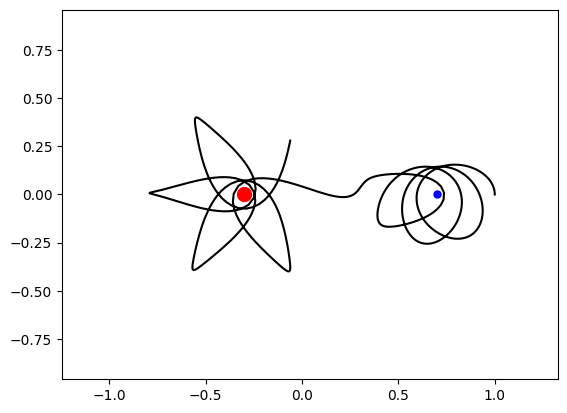

In [8]:
import matplotlib.pyplot as plt
fig=plt.figure()
ax=fig.gca()

rs=Ys[:,:3]
ax.plot(rs[:,0],rs[:,1],'k-')
ax.plot([-alfa],[0],'ro',ms=10)
ax.plot([1-alfa],[0],'bo',ms=5)

from pymcel.plot import fija_ejes_proporcionales
fija_ejes_proporcionales(ax,Ys[:,:2],ycm=0);

Transformándola al sistema de referencia inercial:

In [9]:
from numpy import zeros_like
rs_ine=zeros_like(rs)
r1=zeros_like(rs)
r2=zeros_like(rs)
for i in range(Nt):
    from spiceypy import rotate,mxv
    R=rotate(-ts[i],3)
    rs_ine[i]=mxv(R,rs[i])

    #Posición de las partículas
    from numpy import array,cos,sin
    r1[i]=array([-alfa*cos(ts[i]),-alfa*sin(ts[i]),0])
    r2[i]=array([(1-alfa)*cos(ts[i]),(1-alfa)*sin(ts[i]),0])

La trayectoria en ambos sistemas de referencia será ahora:

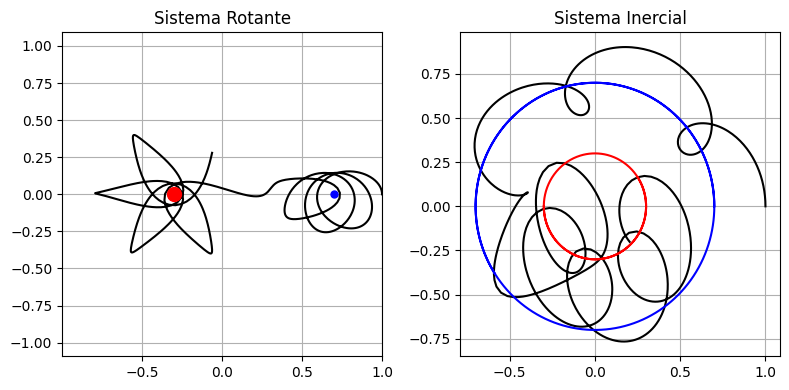

In [10]:
fig,axs=plt.subplots(1,2,figsize=(8,4))

axs[0].plot(rs[:,0],rs[:,1],'k-')
axs[0].plot([-alfa],[0],'ro',ms=10)
axs[0].plot([1-alfa],[0],'bo',ms=5)
axs[0].set_title("Sistema Rotante")
axs[0].grid()
fija_ejes_proporcionales(axs[0],rs[:,:2],ycm=0);

axs[1].plot(rs_ine[:,0],rs_ine[:,1],'k-')
axs[1].plot(r1[:,0],r1[:,1],'r-')
axs[1].plot(r2[:,0],r2[:,1],'b-')
axs[1].set_title("Sistema Inercial")
axs[1].grid()
fija_ejes_proporcionales(axs[0],(rs_ine[:,:2],r1,r2),ycm=0);

fig.tight_layout()

### Un algoritmo general para el CRTBP

La siguiente rutina contiene todos los elementos para la solución al problema del CRTBP:

In [12]:
def crtbp_solucion(alfa,ro,vo,ts):
    #Condiciones iniciales
    from numpy import array,concatenate
    Yo=concatenate((array(ro),array(vo)))

    #Solución
    from scipy.integrate import odeint
    Ys=odeint(edm_crtbp,Yo,ts,args=(alfa,))
    rs_rot=Ys[:,:3]
    vs_rot=Ys[:,3:]
    
    #Transformación al sistema inercial de coordenadas
    from numpy import array,zeros_like
    rs_ine=zeros_like(rs_rot)
    vs_ine=zeros_like(vs_rot)
    r1_ine=zeros_like(rs_rot)
    r2_ine=zeros_like(rs_rot)
    ez=array([0,0,1])
    
    for i in range(len(ts)):
        from spiceypy import rotate,mxv,vcrss
        #Transformar al sistema inercial
        R=rotate(-ts[i],3)
        rs_ine[i]=mxv(R,rs_rot[i])
        vs_ine[i]=mxv(R,vs_rot[i]+vcrss(ez,rs_rot[i]))
        #Posición de las partículas masivas
        from numpy import array,cos,sin
        r1_ine[i]=array([-alfa*cos(ts[i]),-alfa*sin(ts[i]),0])
        r2_ine[i]=array([(1-alfa)*cos(ts[i]),(1-alfa)*sin(ts[i]),0])
        
    return rs_rot,vs_rot,rs_ine,vs_ine,r1_ine,r2_ine

Usémosla para hacer una animación:

/tmp/ipykernel_10048/951979818.py:32: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  punto_rot.set_data(rs_rot[it,0],rs_rot[it,1])
/tmp/ipykernel_10048/951979818.py:33: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  punto_ine.set_data(rs_ine[it,0],rs_ine[it,1])
/tmp/ipykernel_10048/951979818.py:34: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  punto1_ine.set_data(r1_ine[it,0],r1_ine[it,1])
/tmp/ipykernel_10048/951979818.py:35: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  punto2_ine.set_data(r2_ine[it,0],r2_ine[it,1])


RuntimeError: The animation function must return a sequence of Artist objects.

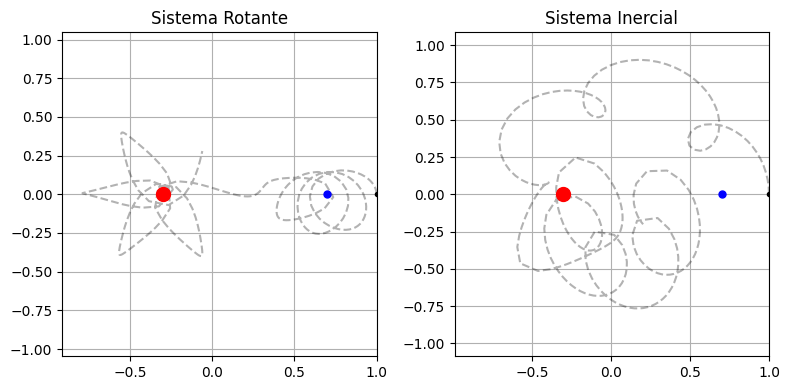

In [13]:
#Tiempos y solucion
from numpy import linspace
Nt=300
ts=linspace(0,10,Nt)
alfa=0.3
ro=[1.0,0.0,0.0]
vo=[0.0,0.45,0.0]
rs_rot,vs_rot,rs_ine,vs_ine,r1_ine,r2_ine=crtbp_solucion(alfa,ro,vo,ts)

#Prepara figura
fig,axs=plt.subplots(1,2,figsize=(8,4))

punto_rot,=axs[0].plot([],[],'k.')
linea_rot,=axs[0].plot(rs_rot[:,0],rs_rot[:,1],'k--',alpha=0.3)
axs[0].plot([-alfa],[0],'ro',ms=10)
axs[0].plot([1-alfa],[0],'bo',ms=5)
axs[0].set_title("Sistema Rotante")
axs[0].grid()
fija_ejes_proporcionales(axs[0],(rs_rot[:,:2],[-alfa,1-alfa]),ycm=0);

punto_ine,=axs[1].plot([],[],'k.')
linea_ine,=axs[1].plot(rs_ine[:,0],rs_ine[:,1],'k--',alpha=0.3)
punto1_ine,=axs[1].plot([],[],'ro',ms=10)
punto2_ine,=axs[1].plot([],[],'bo',ms=5)
axs[1].set_title("Sistema Inercial")
axs[1].grid()
fija_ejes_proporcionales(axs[1],(rs_ine[:,:2],r1,r2),ycm=0);
fig.tight_layout()

#Rutina de animación
def animacion(it):
    punto_rot.set_data(rs_rot[it,0],rs_rot[it,1])
    punto_ine.set_data(rs_ine[it,0],rs_ine[it,1])
    punto1_ine.set_data(r1_ine[it,0],r1_ine[it,1])
    punto2_ine.set_data(r2_ine[it,0],r2_ine[it,1])
    
#Animación
from matplotlib import animation
anim=animation.FuncAnimation(fig,animacion,frames=Nt,interval=5,blit=True,repeat=False);

O si desea tener más control:

In [14]:
from IPython.display import HTML
from matplotlib import rcParams
rcParams['animation.embed_limit']=2**128
HTML(anim.to_jshtml())

NameError: name 'anim' is not defined

<hr/>

Para explorar más cuadernos del libro vaya al [repositorio de en GitHub](https://github.com/seap-udea/pymcel/tree/main/ejemplos/cuadernos-libro)